In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

In [2]:
 # MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software. #
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [3]:
# mit fashion mnist 데이터 셋의 일부를 약간 변형하여 만든 과제를 위한 데이터

In [4]:
#tensorflow keras dataset에서 가져온 데이타셋.
train_image = np.load('hw_train_image.npy')
train_label = np.load('hw_train_label.npy')

In [5]:
train_image.shape

(18000, 28, 28)

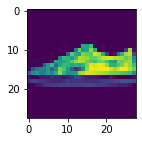

In [6]:
plt.figure(figsize=(2,2))
plt.imshow(train_image[0])
plt.show()

In [7]:
print("정답 : %d" %train_label[0])

정답 : 1


In [8]:
class_name = {}
class_name[0] = 'sandal'
class_name[1] = 'sneaker'
class_name[2] = 'ankle boot'

In [9]:
# 훈련 데이터 셔플
index = np.array(range(len(train_image)))
np.random.shuffle(index)
train_image = train_image[index]
train_label = train_label[index]

In [10]:
# 데이터 전처리 : 필요하다면 원하는대로 수정할 것. (단 openCV등 패키지는 사용불가하고, 넘파이만 이용해서 전처리할 것.)
train_image = (train_image -[128]) / 128

In [11]:
# 훈련데이터와 검증데이터 분리 
sp = int(1e4)  # 원하는 숫자로 변경 가능.
train_x = train_image[:sp]
train_y = train_label[:sp].astype(np.int32)
valid_x = train_image[sp:]
valid_y = train_label[sp:].astype(np.int32)

In [12]:
aa = train_x[0][:]

In [13]:
# 토치 텐서로 변환
train_x = torch.FloatTensor(train_x).view(-1,1, 28,28)
train_y = torch.LongTensor(train_y)
valid_x = torch.FloatTensor(valid_x).view(-1,1,28,28)
valid_y = torch.LongTensor(valid_y)

In [ ]:
class net(torch.nn.Module):

    
    def __init__(self):
        super(net, self).__init__()
        
        #input (num_batch, channel=1, 28, 28)
        self.input_size = 28
        # [batch, 1, 28, 28]
        #생각한 신경망 모델로 변환할 것. (Conv2d, Linear 조합 이용.)

        self.conv1  = nn.Conv2d(1, 16, kernel_size = 3, stride=1, padding=1)
        self.conv2  = nn.Conv2d(16, 32, kernel_size = 3, stride=1, padding=1)
        self.conv3  = nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=1)
        self.conv4  = nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1)
        
        self.conv1_size = ((self.input_size-self.conv1.kernel_size[0]+2*self.conv1.padding[0])//self.conv1.stride[0]+1)//2
        # [batch, 32, (28-3)/1+1, 26]
        print(self.conv1_size)

        self.conv2_size = ((self.conv1_size - self.conv2.kernel_size[0]+2*self.conv2.padding[0])//self.conv2.stride[0]+1)//2
        # [batch, 64, (26-3)/1+1, 25]
        print(self.conv2_size)

        self.conv3_size = ((self.conv2_size - self.conv3.kernel_size[0]+2*self.conv3.padding[0])//self.conv3.stride[0]+1)//2
        # [batch, 128, (25-2+2)/1+1, 26]
        print(self.conv3_size)

        self.conv4_size = ((self.conv3_size - self.conv4.kernel_size[0]+2*self.conv4.padding[0])//self.conv4.stride[0]+1)//2
        # [batch, 128, (25-2+2)/1+1, 26]
        print(self.conv3_size)

        self.fc     = nn.Linear(self.conv4.out_channels * self.conv4_size**2, 3)
        
    
    
    def forward(self, x): #구현한 신경망 모델에 따라 적절히 변형할 것
        self.batch_size = x.shape[0]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = torch.sigmoid(self.fc(x))
        return x
    
    def predict(self, image): #test image는 넘파이 (28,28) 형상 2d 배열임. 테스트 이미지 1장을 입력했을 때 결과가 출력되도록 할 것.
        image = (image -[128])/128
        image = torch.from_numpy(image).float()
        image = image.view(-1,1, 28,28)
        out   = self.forward(image).view(-1)
        return out.argmax().item()
    
    def accuracy(self, input_data, target_data):
        predict = self.forward(input_data).argmax(axis=1)
        correct_cnt = sum(predict==target_data)
        return correct_cnt.item()/len(target_data)
    
    def save(self, name):
        torch.save(self.state_dict(), name + '.pt')
        print('Models saved successfully')
    
    def load(self, name):
        self.load_state_dict(torch.load(name + '.pt'))
        print ('Models loaded succesfully')

In [ ]:
cnn = net()

In [ ]:
cnn.accuracy(train_x, train_y)

In [ ]:
class trainer:
    
    def __init__(self, net, lr, figname, train_x, train_y, valid_x, valid_y):
        
        self.net = net
        self.lrate = lr
        self.name = figname
        self.train_x, self.train_y = train_x, train_y
        self.valid_x, self.valid_y = valid_x, valid_y
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lrate)
        self.loss_layer    = nn.CrossEntropyLoss()
        self.train_loss_history = [] 
        self.valid_acc_history = [] 
    
    def plot(self, train_loss, valid_acc):
        clear_output(True)
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.title('train loss')
        plt.plot(train_loss, 'k-')
        plt.subplot(122)
        plt.title('valid acc')
        plt.plot(valid_acc)
        plt.savefig(self.name +'.png')
        plt.show()
    
    def train(self, epoch=10):
        
        for j in range(epoch):
            
            train_loss = 0
            idx = np.array(range(sp))
            np.random.shuffle(idx)
            train_x = self.train_x[idx]
            train_y = self.train_y[idx]
            batch_size = 500 # 필요한 경우 변경
            for k in range(len(train_x)//batch_size): #필요한 경우 레인지 내 변수 변경
                
                self.optimizer.zero_grad()
                loss = self.loss_layer(self.net.forward(train_x[batch_size*k:batch_size*(k+1)]), train_y[batch_size*k:batch_size*(k+1)])
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                
                
            self.train_loss_history.append(train_loss)
            self.valid_acc_history.append(self.net.accuracy(valid_x, valid_y))
            
            self.plot(self.train_loss_history, self.valid_acc_history)
            if np.argmax(self.valid_acc_history) == j:
                print("%d-th epoch에서 진척이 있었음." %(j+1))
                savename = 'cnn' + self.name
                self.net.save(savename)
            else:
                print("%d-th epoch에서는 진척 없음." %(j+1))
            print("현재 검증 데이터의 분류 성공율 최댓값은 %.3f%%" %(100*np.max(self.valid_acc_history)))
        print("훈련 종료.")
        print("%d번째 epoch에서 검증 정답율 최대" %(np.argmax(self.valid_acc_history)+1))




In [ ]:
# 원하는 학습율로 변경
tt = trainer(cnn, 1e-3, 'lr1e-3', train_x, train_y, valid_x, valid_y)

In [ ]:
# 원하는 회수로 변경
tt.train(20)

In [ ]:
cnn.accuracy(train_x, train_y)

In [ ]:
cnn.accuracy(valid_x, valid_y)

In [ ]:
# 제출한 세이브파일을 로드할 수 있도록 파일 네임을 입력해서 제출
cnn.load('cnnlr1e-3') 
cnn.accuracy(valid_x, valid_y)

In [ ]:
# 아래 부분을 채점을 위한 부분임. 
# 아래 부분은 변경불가!
#이 부분이 실행되지 않으면 채점불가하니, 아래 부분이 실행될 수 있도록 과제를 제출 할 것. 
# test data는 개수만 다를 뿐 초기형태는 훈련데이터와 동일한 (28,28) 2d 넘파이 배열임.
test_image = np.load('hw_test_image.npy')
test_label = np.load('hw_test_label.npy')
ctr = 0
for i, img in enumerate(test_image):
    guess = cnn.predict(img)
    if guess == test_label[i]:
        ctr +=1
print("테스트 데이터 분류 성공율 : %.2f%%" %(100*ctr/len(test_label)))
    